In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, KFold, cross_val_score, cross_val_predict, RandomizedSearchCV, ParameterSampler
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, FunctionTransformer, LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.base import clone, BaseEstimator, TransformerMixin
import statsmodels.api as sm
from sklearn.svm import SVR
from catboost import CatBoostRegressor, Pool

import time, math, warnings

from tqdm.notebook import tqdm
from copy import deepcopy

from __future__ import annotations
from typing import Iterable, Optional, List, Dict, Tuple

In [15]:
Ames_original = pd.read_csv('Ames_HousePrice.csv', index_col=0)

Ames = Ames_original.copy()

# Hardcode NAN encoding where appropriate

bath_cols = ["FullBath", "HalfBath", "BsmtFullBath", "BsmtHalfBath"]
Ames[bath_cols] = Ames[bath_cols].fillna(0)

garage_cols = ['GarageArea', 'GarageCars']
Ames[garage_cols] = Ames[garage_cols].fillna(0)

basement_cols = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF']
Ames[basement_cols] = Ames[basement_cols].fillna(0)

Ames['MasVnrArea'] = Ames['MasVnrArea'].fillna(0)
Ames['PoolArea'] = Ames['PoolArea'].fillna(0)

# Convert the below numeric features to categorical features
Ames['MSSubClass'] = Ames['MSSubClass'].astype('object')
Ames['YrSold'] = Ames['YrSold'].astype('object')
Ames['MoSold'] = Ames['MoSold'].astype('object')

In [4]:
X_fe = Ames.copy()

# Targeted Feature Engineering
X_fe["TotalSF"] = X_fe["GrLivArea"] + X_fe["TotalBsmtSF"]
X_fe["HouseAgeSinceRemod"] = X_fe["YrSold"].astype(int) - X_fe["YearRemodAdd"].astype(int)

HalfBath_coeff = 0.48
BsmtFullBath_coeff = 1.18
BsmtHalfBath_coeff = 0.1
                         

X_fe['TotalBaths'] = (X_fe['FullBath'] + 
                      HalfBath_coeff * X_fe['HalfBath'] + 
                      BsmtFullBath_coeff * X_fe['BsmtFullBath'] + 
                      BsmtHalfBath_coeff * X_fe['BsmtHalfBath'])


# Add Interactions
X_fe['TotalSF_x_Qual'] = X_fe['TotalSF'] * X_fe['OverallQual'] ** 1.35

X_fe = X_fe.drop(columns=['SalePrice','PID'])
y = Ames['SalePrice']

In [253]:
# def _patch_ct(ct: ColumnTransformer):
#     try:
#         params = ct.get_params(deep=False)
#         if "force_int_remainder_cols" in params:
#             val = params["force_int_remainder_cols"]
#             if val == "deprecated" or not isinstance(val, (bool,)):
#                 ct.set_params(force_int_remainder_cols=False)
#     except Exception:
#         if hasattr(ct, "__dict__") and "force_int_remainder_cols" in ct.__dict__:
#             del ct.__dict__["force_int_remainder_cols"]

# def patch_sklearn_objects(obj):
#     if isinstance(obj, ColumnTransformer):
#         _patch_ct(obj)
#         for _, trans, _ in getattr(obj, "transformers", []):
#             if isinstance(trans, (Pipeline, ColumnTransformer)):
#                 patch_sklearn_objects(trans)
#         return obj

#     if isinstance(obj, Pipeline):
#         for _, step in obj.steps:
#             if isinstance(step, (Pipeline, ColumnTransformer)):
#                 patch_sklearn_objects(step)
#         return obj

#     for attr in ("named_steps", "_final_estimator"):
#         if hasattr(obj, attr):
#             sub = getattr(obj, attr)
#             try:
#                 patch_sklearn_objects(sub)
#             except Exception:
#                 pass
#     return obj

In [5]:
# === ONE-CELL START: encoders + pipelines + CV helper (no-TTR, short params) ===
# ----------------------------- Ordinal maps -----------------------------
ORDINAL_ORDER: Dict[str, List[str]] = {
    'Electrical': ['Mix', 'FuseP', 'FuseF', 'FuseA', 'SBrkr'],
    'LotShape': ['IR3', 'IR2', 'IR1', 'Reg'],
    'Utilities': ['ELO', 'NoSeWa', 'NoSewr', 'AllPub'],
    'LandSlope': ['Sev', 'Mod', 'Gtl'],
    'ExterQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'ExterCond': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'BsmtQual': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'BsmtCond': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'BsmtExposure': ['None', 'No', 'Mn', 'Av', 'Gd'],
    'BsmtFinType1': ['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    'BsmtFinType2': ['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    'HeatingQC': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'KitchenQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'Functional': ['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],
    'FireplaceQu': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'GarageFinish': ['None', 'Unf', 'RFn', 'Fin'],
    'GarageQual': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'GarageCond': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'PavedDrive': ['N', 'P', 'Y'],
    'PoolQC': ['None', 'Fa', 'TA', 'Gd', 'Ex'],
    'Fence': ['None', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv']
}

# --------------------- Utilities (metrics + helpers) --------------------
def rmse(y_true, y_pred) -> float:
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

from pandas.api.types import CategoricalDtype
def _is_object_like(s: pd.Series) -> bool:
    return s.dtype.kind in ("O", "b") or isinstance(s.dtype, CategoricalDtype)

# --------------------------- Quantile capper ----------------------------
class QuantileCapper(BaseEstimator, TransformerMixin):
    def __init__(self, lower_q: float = 0.01, upper_q: float = 0.99):
        self.lower_q = lower_q
        self.upper_q = upper_q

    def fit(self, X, y=None):
        df = X if isinstance(X, pd.DataFrame) else pd.DataFrame(X)
        self.feature_names_in_ = list(df.columns)
        self.lower_ = df.quantile(self.lower_q)
        self.upper_ = df.quantile(self.upper_q)
        return self

    def transform(self, X):
        df = X if isinstance(X, pd.DataFrame) else pd.DataFrame(X, columns=self.feature_names_in_)
        df = df.clip(self.lower_, self.upper_, axis=1)
        return df.infer_objects(copy=False)   # <--- this silences the warning

    def get_feature_names_out(self, input_features=None):
        return np.asarray(self.feature_names_in_, dtype=object)

# ------------------------- Preprocessor builder -------------------------
def build_preprocessor(
    df: pd.DataFrame,
    *,
    mode: str = "linear",  # 'linear' -> log/scale; 'tree' -> no log/scale on numerics
    numeric_cap: Optional[Iterable[str]] = None,
    lower_q: float = 0.01,
    upper_q: float = 0.99,
    log_cols: Optional[Iterable[str]] = None,          # (linear mode only)
    scale_features: Optional[Iterable[str]] = None,    # (linear mode only)
    zero_impute_cols: Optional[Iterable[str]] = None   # exact zeros for these numerics
) -> ColumnTransformer:

    if mode not in {"linear", "tree"}:
        raise ValueError("mode must be 'linear' or 'tree'")

    num_all = df.select_dtypes(include=["number"]).columns.tolist()
    cat_all = [c for c in df.columns if _is_object_like(df[c])]

    ordinal_explicit = [c for c in ORDINAL_ORDER.keys() if c in df.columns and c != "Electrical"]
    nominal_all = [c for c in cat_all if c not in ORDINAL_ORDER.keys()]

    zero_impute_cols = list(zero_impute_cols or ["BsmtFullBath", "BsmtHalfBath"])
    zero_impute_cols = [c for c in zero_impute_cols if c in num_all]

    default_cap = [
        "LotArea","LotFrontage","MasVnrArea","TotalBsmtSF",
        "BsmtFinSF1","BsmtFinSF2","BsmtUnfSF",
        "1stFlrSF","2ndFlrSF","LowQualFinSF","GrLivArea",
        "GarageArea","WoodDeckSF","OpenPorchSF","EnclosedPorch",
        "3SsnPorch","ScreenPorch","PoolArea","MiscVal",
        "TotalSF",
    ]
    numeric_cap = set(numeric_cap or default_cap) & set(num_all)

    if mode == "linear":
        log_cols = set(log_cols or [
            "LotArea", "LotFrontage", "MasVnrArea",
            "BsmtFinSF1","BsmtFinSF2","BsmtUnfSF","TotalBsmtSF",
            "1stFlrSF","2ndFlrSF","LowQualFinSF","GrLivArea",
            "GarageArea","WoodDeckSF","OpenPorchSF","EnclosedPorch",
            "3SsnPorch","ScreenPorch","PoolArea","MiscVal","TotalSF",
        ])
        scale_features = set(scale_features or (
            {
                "GrLivArea","LotFrontage","LotArea","MasVnrArea",
                "BsmtFinSF1","BsmtFinSF2","BsmtUnfSF","TotalBsmtSF",
                "1stFlrSF","2ndFlrSF","LowQualFinSF","GarageArea",
                "WoodDeckSF","OpenPorchSF","EnclosedPorch","3SsnPorch",
                "ScreenPorch","PoolArea","MiscVal","TotalSF",
            }
            | {"BsmtFullBath","BsmtHalfBath","FullBath","HalfBath",
               "BedroomAbvGr","KitchenAbvGr","TotRmsAbvGrd","Fireplaces",
               "GarageCars","TotalBaths"}
            | {"OverallQual","OverallCond"}
            | {"HouseAgeSinceRemod","GarageAge"}
        ))
    else:
        log_cols = set()
        scale_features = set()

    num_log_cap   = sorted((log_cols & numeric_cap) & set(num_all))
    num_log_plain = sorted((log_cols - numeric_cap) & set(num_all))
    num_cap_only  = sorted((numeric_cap - log_cols) & set(num_all))
    used_linear_buckets = set(num_log_cap) | set(num_log_plain) | set(num_cap_only)
    num_plain = sorted([c for c in num_all if c not in used_linear_buckets])

    def make_imputer_for(cols: List[str]) -> ColumnTransformer:
        zero_cols = [c for c in cols if c in zero_impute_cols]
        mean_cols = [c for c in cols if c not in zero_impute_cols]
        transformers = []
        if zero_cols:
            transformers.append(("zero_imp", SimpleImputer(strategy="constant", fill_value=0), zero_cols))
        if mean_cols:
            transformers.append(("mean_imp", SimpleImputer(strategy="mean"), mean_cols))
        return ColumnTransformer(transformers=transformers, remainder="drop", verbose_feature_names_out=False)

    def numeric_branch(cols: List[str], *, cap: bool, log: bool, scale: bool):
        if not cols:
            return None
        steps = []
        if cap:
            steps.append(("cap", QuantileCapper(lower_q=lower_q, upper_q=upper_q)))
        steps.append(("impute", make_imputer_for(cols)))
        if log:
            steps.append(("log1p", FunctionTransformer(np.log1p, validate=False)))
        if scale:
            steps.append(("scale", StandardScaler()))
        return ("_tmp", Pipeline(steps=steps), cols)

    branches = []
    branches += [numeric_branch(num_log_cap,   cap=True,  log=(mode=="linear"), scale=(mode=="linear"))] or []
    branches += [numeric_branch(num_log_plain, cap=False, log=(mode=="linear"), scale=(mode=="linear"))] or []
    branches += [numeric_branch(num_cap_only,  cap=True,  log=False,           scale=(mode=="linear"))] or []
    branches += [numeric_branch(num_plain,     cap=False, log=False,           scale=(mode=="linear"))] or []
    branches = [b for b in branches if b is not None]

    electrical_pipe = Pipeline(steps=[
        ("impute_mf", SimpleImputer(strategy="most_frequent")),
        ("ordinal",   OrdinalEncoder(categories=[ORDINAL_ORDER["Electrical"]],
                                     handle_unknown="use_encoded_value", unknown_value=-1)),
    ]) if "Electrical" in df.columns else "drop"

    if "Electrical" in nominal_all: nominal_all.remove("Electrical")
    if "Electrical" in ordinal_explicit: ordinal_explicit.remove("Electrical")

    ordinal_pipe = (
        Pipeline(steps=[
            ("impute_none", SimpleImputer(strategy="constant", fill_value="None")),
            ("ordinal", OrdinalEncoder(categories=[ORDINAL_ORDER[c] for c in ordinal_explicit],
                                       handle_unknown="use_encoded_value", unknown_value=-1))
        ])
        if ordinal_explicit else "drop"
    )

    nominal_pipe = (
        Pipeline(steps=[
            ("impute_none", SimpleImputer(strategy="constant", fill_value="None")),
            ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
        ])
        if nominal_all else "drop"
    )

    transformers = []
    if "Electrical" in df.columns:
        transformers.append(("elect", electrical_pipe, ["Electrical"]))
    name_map = ["num_log_cap","num_log_plain","num_cap","num_plain"]
    for i, b in enumerate(branches):
        transformers.append((name_map[i], b[1], b[2]))
    if ordinal_explicit:
        transformers.append(("ordinal", ordinal_pipe, ordinal_explicit))
    if nominal_all:
        transformers.append(("nominal", nominal_pipe, nominal_all))

    pre = ColumnTransformer(
        transformers=transformers,
        remainder="drop",
        sparse_threshold=0.3,
        verbose_feature_names_out=False
    )
    return pre



def make_catboost_pipe(df_schema, **cb_params):
    pre = build_preprocessor(df_schema, mode="tree", log_cols=[], scale_features=[])
    # set safe defaults only if not provided
    cb_params = dict(cb_params)
    cb_params.setdefault("loss_function", "RMSE")
    cb_params.setdefault("random_state", 42)
    cb_params.setdefault("verbose", 0)
    cb_params.setdefault("thread_count", -1)
    reg = CatBoostRegressor(**cb_params)
    return Pipeline([("prep", pre), ("reg", reg)])

def make_linear_pipe(
    df_schema: pd.DataFrame,
    *,
    model: str = "ridge",                     # 'ridge' | 'lasso' | 'enet'  (pass kwargs via model_kwargs)
    model_kwargs: Optional[dict] = None,
    # preprocessing knobs (optional; use defaults if omitted)
    numeric_cap: Optional[Iterable[str]] = None,
    lower_q: float = 0.01,
    upper_q: float = 0.99,
    log_cols: Optional[Iterable[str]] = None,
    scale_features: Optional[Iterable[str]] = None,
    zero_impute_cols: Optional[Iterable[str]] = None,
) -> Pipeline:
    """
    Linear pipeline with fold-safe preprocessing. NO TTR — keep params short (reg__alpha etc).
    Target logging is handled by the evaluator.
    """
    model_kwargs = model_kwargs or {}
    key = (model or "").lower()
    if key == "ridge":
        model_kwargs = dict(model_kwargs or {})
        model_kwargs.setdefault("max_iter", 200_000)
        model_kwargs.setdefault("tol", 1e-3)
        base = Ridge(**model_kwargs)
    elif key == "lasso":
        base = Lasso(max_iter=200_000, tol=1e-3, **model_kwargs)
    elif key == "enet":
        base = ElasticNet(max_iter=200_000, tol=1e-3, **model_kwargs)
    else:
        raise ValueError("model must be 'ridge' | 'lasso' | 'enet'")

    pre = build_preprocessor(
        df_schema, mode="linear",
        numeric_cap=numeric_cap, lower_q=lower_q, upper_q=upper_q,
        log_cols=log_cols, scale_features=scale_features,
        zero_impute_cols=zero_impute_cols
    )
    return Pipeline([("prep", pre), ("reg", base)])

def make_histgb_pipe(
    df_schema: pd.DataFrame,
    *,
    hgb_kwargs: Optional[dict] = None,
    numeric_cap: Optional[Iterable[str]] = None,
    lower_q: float = 0.01,
    upper_q: float = 0.99,
    zero_impute_cols: Optional[Iterable[str]] = None,
) -> Pipeline:
    """
    Tree pipeline: cap + impute + encoders; NO log/scale on features.
    """
    hgb_kwargs = hgb_kwargs or {"random_state": 42}
    pre = build_preprocessor(
        df_schema, mode="tree",
        numeric_cap=numeric_cap, lower_q=lower_q, upper_q=upper_q,
        log_cols=[], scale_features=[],
        zero_impute_cols=zero_impute_cols
    )
    return Pipeline([("prep", pre), ("reg", HistGradientBoostingRegressor(**hgb_kwargs))])


# ---------------------- Quick CV leaderboard helper --------------------
def cv_eval_models(
    X: pd.DataFrame,
    y: pd.Series | np.ndarray,
    models: list[tuple[str, BaseEstimator]],
    *,
    cv: int = 5,
    random_state: int = 42,
    log_target: bool = True,
    show_progress: bool = True,
) -> pd.DataFrame:

    y_np = y.to_numpy() if hasattr(y, "to_numpy") else np.asarray(y)
    kf = KFold(n_splits=cv, shuffle=True, random_state=random_state)
    rows = []

    # Outer loop: models (optional outer bar)
    model_iter = models if not show_progress else tqdm(models, desc="Models", leave=True)

    for name, est in model_iter:
        fold_rmses, oof = [], np.zeros(len(y_np), dtype=float)
        # Inner loop: folds (progress bar per model)
        fold_iter = range(cv) if not show_progress else tqdm(range(cv), desc=f"{name} folds", leave=False)

        for i, (tr, va) in zip(fold_iter, kf.split(X)):
            X_tr, X_va = X.iloc[tr], X.iloc[va]
            y_tr, y_va = y_np[tr], y_np[va]

            y_tr_used = np.log1p(y_tr) if log_target else y_tr
            est.fit(X_tr, y_tr_used)

            pred = est.predict(X_va)
            if log_target:
                pred = np.expm1(pred)

            fold_rmses.append(float(np.sqrt(((y_va - pred) ** 2).mean())))
            oof[va] = pred

        # full fit
        y_full_used = np.log1p(y_np) if log_target else y_np
        est.fit(X, y_full_used)
        y_full = est.predict(X)
        if log_target:
            y_full = np.expm1(y_full)

        rows.append({
            "model": name,
            "cv_rmse_mean": float(np.mean(fold_rmses)),
            "cv_rmse_std":  float(np.std(fold_rmses, ddof=0)),
            "r2_cv":  float(r2_score(y_np, oof)),
            "r2_full": float(r2_score(y_np, y_full)),
        })

    return pd.DataFrame(rows).sort_values("cv_rmse_mean").reset_index(drop=True)

In [ ]:
warnings.filterwarnings("ignore", category=UserWarning)
pd.set_option('future.no_silent_downcasting', True)

# --- 1) Small helpers ---

def neg_rmse_scorer():
    # scikit-learn has "neg_root_mean_squared_error" but we'll make it explicit
    def rmse(y_true, y_pred):
        return float(np.sqrt(np.mean((y_true - y_pred)**2)))
    return make_scorer(rmse, greater_is_better=False)

def build_ttr_from_params(X_schema: pd.DataFrame, **cb_params):
    """
    Build your preprocessing+CatBoost pipeline, then wrap in TTR so CV is log1p→expm1.
    Using your make_catboost_pipe avoids the 'RL' casting error.
    """
    pipe = make_catboost_pipe(X_schema, **cb_params)  # <-- YOUR function
    ttr = TransformedTargetRegressor(
        regressor=pipe,
        func=np.log1p,
        inverse_func=np.expm1,
        check_inverse=False,
    )
    return ttr

# --- 2) Tuner with lightweight progress ---

def tune_catboost_with_progress(
    X: pd.DataFrame,
    y: pd.Series,
    *,
    n_iter: int = 60,
    folds: int = 5,
    random_state: int = 42,
    base_params: dict | None = None,
    search_space: dict | None = None,
    show_every: int = 1,   # print every iteration
):
    """
    Random-sample hyperparams; K-fold CV each; print compact progress lines.
    Returns (best_params, best_cv_rmse, final_model_fit_on_all_data).
    """
    rng = np.random.RandomState(random_state)

    # sensible default space (narrow enough to be efficient; broad enough to explore)
    default_space = {
        "depth":               [4,5,6,7],
        "iterations":          [2000, 3000, 4500, 6000, 7500],
        "learning_rate":       np.logspace(np.log10(0.012), np.log10(0.08), 15),
        "l2_leaf_reg":         np.logspace(np.log10(1.0), np.log10(10.0), 10),
        "subsample":           np.linspace(0.65, 1.0, 8),
        "colsample_bylevel":   np.linspace(0.45, 1.0, 8),
        "bagging_temperature": np.linspace(0.0, 3.0, 10),
        "random_strength":     np.linspace(0.0, 2.0, 10),
        "min_data_in_leaf":    [60, 90, 120, 150, 180, 220, 260, 300],
    }
    space = search_space or default_space

    # base params (fixed) — you can seed with something you liked before
    fixed = dict(
        loss_function="RMSE",
        random_state=random_state,
        verbose=0,
        thread_count=-1,   # keep n_jobs=1 in CV to avoid oversubscription
    )
    if base_params:
        fixed.update(base_params)

    sampler = ParameterSampler(space, n_iter=n_iter, random_state=random_state)

    kf = KFold(n_splits=folds, shuffle=True, random_state=random_state)
    scorer = neg_rmse_scorer()

    best_rmse = np.inf
    best_params = None
    history = []

    print(f"Fitting {folds} folds for each of {n_iter} candidates → total {n_iter*folds} fits")
    start = time.time()

    for i, sampled in enumerate(sampler, start=1):
        params = deepcopy(fixed)
        params.update(sampled)

        # build TTR( make_catboost_pipe(...) ) each time so CatBoost sees only numeric arrays
        model = build_ttr_from_params(X, **params)

        # cross-validated RMSE in *dollars* (thanks to TTR inverse)
        scores = cross_val_score(model, X, y, cv=kf, scoring=scorer, n_jobs=1)
        rmse_dollars = -np.mean(scores)

        history.append((i, rmse_dollars, params))
        if rmse_dollars < best_rmse:
            best_rmse = rmse_dollars
            best_params = deepcopy(params)

        if (i % show_every) == 0:
            elapsed = time.time() - start
            print(f"[{i:>3}/{n_iter}] CV RMSE = {rmse_dollars:,.0f}  |  best = {best_rmse:,.0f}  |  {elapsed:,.0f}s")

    # Fit final model on all data with the best params
    final_model = build_ttr_from_params(X, **best_params).fit(X, y)

    print("\nDone.")
    print(f"Best CV RMSE: {best_rmse:,.0f}")
    print("Best params:", {k: best_params[k] for k in sorted(best_params)})

    return best_params, best_rmse, final_model, history

# --- 3) Example call (runs now) ---

# (Optional) seed with a set you liked previously
seed_params = {'loss_function': 'RMSE',
 'random_state': 42,
 'verbose': 0,
 'thread_count': -1,
 'subsample': np.float64(0.7000000000000001),
 'random_strength': np.float64(1.3333333333333333),
 'min_data_in_leaf': 90,
 'learning_rate': np.float64(0.027057333345112382),
 'l2_leaf_reg': np.float64(7.742636826811269),
 'iterations': 7500,
 'depth': 6,
 'colsample_bylevel': np.float64(0.5285714285714286),
 'bagging_temperature': np.float64(0.0)}

best_params, best_cv_rmse, cb_final_ttr, search_log = tune_catboost_with_progress(
    X_fe, y,
    n_iter=80,          # bump this as high as you want
    folds=5,
    random_state=42,
    base_params=None,  # you can set None if you don’t want a seed
    show_every=1
)

# You can now use cb_final_ttr.predict(X_fe) safely (no 'RL' error),
# and the predictions are in *dollars* because of TTR inverse_func.

In [18]:
best_params

{'loss_function': 'RMSE',
 'random_state': 42,
 'verbose': 0,
 'thread_count': -1,
 'subsample': np.float64(0.7000000000000001),
 'random_strength': np.float64(1.3333333333333333),
 'min_data_in_leaf': 90,
 'learning_rate': np.float64(0.027057333345112382),
 'l2_leaf_reg': np.float64(7.742636826811269),
 'iterations': 7500,
 'depth': 6,
 'colsample_bylevel': np.float64(0.5285714285714286),
 'bagging_temperature': np.float64(0.0)}

In [19]:
# -- (B) build your CatBoost pipeline (tree-mode preproc handles categoricals safely)
cb_pipe = make_catboost_pipe(X_fe, **best_params)


In [24]:
def oof_rmse_est(estimator, X, y, folds=5, seed=42, show_progress=True):
    kf = KFold(n_splits=folds, shuffle=True, random_state=seed)
    preds = np.zeros(len(y), dtype=float)
    rmses = []
    iterator = list(kf.split(X))
    if show_progress:
        from tqdm.auto import tqdm
        iterator = tqdm(iterator, desc=f"{folds}-fold OOF", unit="fold")

    for tr, va in iterator:
        est = clone(estimator)
        est.fit(X.iloc[tr], y.iloc[tr])
        pred = est.predict(X.iloc[va])  # already in dollars if estimator is TTR
        rmse_fold = np.sqrt(np.mean((y.iloc[va].to_numpy() - pred)**2))
        rmses.append(rmse_fold)
        preds[va] = pred

    return float(np.mean(rmses)), float(np.std(rmses, ddof=0)), preds

# usage
ttr_model = build_ttr_from_params(X_fe, **best_params)
mean_rmse, std_rmse, oof_pred = oof_rmse_est(ttr_model, X_fe, y)
print(f"OOF RMSE: {mean_rmse:,.0f} ± {std_rmse:,.0f}")

5-fold OOF:   0%|          | 0/5 [00:00<?, ?fold/s]

OOF RMSE: 19,041 ± 3,058


In [26]:
def _mad(x: pd.Series) -> float:
    med = np.median(x)
    return float(np.median(np.abs(x - med))) if len(x) else 0.0

def make_oof_tables(
    X_fe: pd.DataFrame,
    y: pd.Series | np.ndarray,
    oof_pred: np.ndarray,
    *,
    row_id: pd.Index | np.ndarray | None = None,
    outlier_rule: str = "mad",   # "mad" | "sigma"
    k: float = 3.5,              # MAD multiplier (≈3.5 ~ 3σ under normality)
    sigma: float = 3.0           # σ multiplier if outlier_rule="sigma"
):
    """
    Returns:
      base   : minimal, merge-friendly OOF table (authoritative)
      x_view : feature-augmented view (for EDA; built from X_fe + base cols)
    """
    n = len(X_fe)
    if len(y) != n or len(oof_pred) != n:
        raise ValueError("Lengths of X_fe, y, and oof_pred must match")

    # Positional key + optional external key
    base = pd.DataFrame({"_idx": np.arange(n, dtype=int)}, index=None)
    if row_id is not None:
        if len(row_id) != n:
            raise ValueError("row_id length must match X_fe length")
        base["row_id"] = np.asarray(row_id)

    # Targets/preds/residuals
    base["y_true"]    = pd.to_numeric(y, errors="coerce").to_numpy()
    base["oof_pred"]  = np.asarray(oof_pred, dtype=float)
    base["residual"]  = base["y_true"] - base["oof_pred"]
    base["abs_resid"] = base["residual"].abs()

    # Robust/σ outlier flag
    if outlier_rule.lower() == "mad":
        med = float(np.median(base["residual"]))
        mad = _mad(base["residual"])
        denom = (1.4826 * mad) if mad > 0 else np.inf  # 1.4826 ~ to σ for normal
        base["is_outlier"] = (np.abs(base["residual"] - med) / denom) > k if np.isfinite(denom) else False
    elif outlier_rule.lower() == "sigma":
        sd = float(base["residual"].std(ddof=1))
        base["is_outlier"] = (base["abs_resid"] > sigma * sd) if sd > 0 else False
    else:
        raise ValueError("outlier_rule must be 'mad' or 'sigma'")

    # DO NOT set _idx as the index; keep it as a column
    base = base.reset_index(drop=True)

    # Feature-augmented view (aligned by position)
    x_view = X_fe.reset_index(drop=True).copy()
    cols_to_add = ["_idx", "y_true", "oof_pred", "residual", "abs_resid", "is_outlier"]
    x_view = pd.concat([x_view, base[cols_to_add]], axis=1)

    return base, x_view

In [27]:
# Authoritative base table + convenient feature-augmented view
base_df_oof, X_oof = make_oof_tables(
    X_fe, y, oof_pred,
    row_id=Ames.index,        # keep a pointer to the original rows
    outlier_rule="mad", k=3.5 # or outlier_rule="sigma", sigma=3.0
)

# For EDA: drop any heavyweight columns you don’t want to carry around
X_oof = X_oof.drop(columns=["TotalSF_x_Qual"], errors="ignore")

# When you need just a subset for plotting/reporting:
plot_df = base_df_oof[["_idx", "y_true", "oof_pred", "residual", "is_outlier"]]

In [103]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

def _sanitize_params(d):
    # convert any np.float64 to plain float/ints for safety
    out = {}
    for k, v in d.items():
        if isinstance(v, (np.generic,)):
            v = v.item()
        out[k] = v
    return out

def get_oof_predictions(
    X, y, best_params, *,
    cv=5, random_state=42, log_target=True, show_progress=True
):
    """
    Returns:
      oof_pred: np.ndarray of dollar predictions (OOF)
      fold_models: list of fitted Pipeline objects (prep + CatBoost)
      stats: dict with cv_rmse, cv_r2, and per_fold metrics
    """
    best_params = _sanitize_params(dict(best_params))
    kf = KFold(n_splits=cv, shuffle=True, random_state=random_state)

    y_np = y.to_numpy() if hasattr(y, "to_numpy") else np.asarray(y, dtype=float)
    oof_pred = np.zeros(len(y_np), dtype=float)
    fold_models, fold_metrics = [], []

    for i, (tr_idx, va_idx) in enumerate(kf.split(X), start=1):
        if show_progress:
            print(f"[fold {i}/{cv}] training…", end=" ")

        # fresh pipeline each fold — this ensures categoricals are encoded
        pipe_fold = make_catboost_pipe(X, **best_params)

        y_tr = np.log1p(y_np[tr_idx]) if log_target else y_np[tr_idx]
        pipe_fold.fit(X.iloc[tr_idx], y_tr)

        pred_raw = pipe_fold.predict(X.iloc[va_idx])
        pred = np.expm1(pred_raw) if log_target else pred_raw
        oof_pred[va_idx] = pred

        rmse = float(np.sqrt(mean_squared_error(y_np[va_idx], pred)))
        r2   = float(r2_score(y_np[va_idx], pred))
        fold_metrics.append({"rmse": rmse, "r2": r2})
        fold_models.append(pipe_fold)

        if show_progress:
            print(f"rmse={rmse:,.0f}, r²={r2:.3f}")

    cv_rmse = float(np.mean([m["rmse"] for m in fold_metrics]))
    cv_r2   = float(np.mean([m["r2"]   for m in fold_metrics]))
    stats = {"cv_rmse": cv_rmse, "cv_r2": cv_r2, "per_fold": fold_metrics}
    return oof_pred, fold_models, stats

# --- run it (ALWAYS pass params explicitly; don't pass a 'pipe' you won't use)
oof_pred, fold_models, cv_stats = get_oof_predictions(
    X_fe, y, best_params, cv=5, random_state=42, log_target=True, show_progress=True
)

print(f"\nCV RMSE (OOF): {cv_stats['cv_rmse']:,.0f}")
print(f"CV R²   (OOF): {cv_stats['cv_r2']:.3f}")

[fold 1/5] training… rmse=18,686, r²=0.943
rmse=24,791, r²=0.900
rmse=18,839, r²=0.941
rmse=16,610, r²=0.946
rmse=16,280, r²=0.942

CV RMSE (OOF): 19,041
CV R²   (OOF): 0.935


In [104]:
from sklearn.model_selection import train_test_split
from sklearn.compose import TransformedTargetRegressor
import numpy as np

# 0) Rebuild the CatBoost pipeline with your winning params
cb_pipe = make_catboost_pipe(X_fe, **best_params)   # best_params from your tuner

# 1) Wrap it so we fit on log1p(y) and predict in dollars
cb_ttr = TransformedTargetRegressor(
    regressor=cb_pipe,
    func=np.log1p,
    inverse_func=np.expm1
)

# 2) Train/val split (optional—useful for a quick sanity check + plots)
X_train, X_test, y_train, y_test = train_test_split(
    X_fe, y, test_size=0.20, random_state=42
)

# 3) Fit and evaluate (preds will be in dollars)
cb_ttr.fit(X_train, y_train)
y_pred_test = cb_ttr.predict(X_test)

from sklearn.metrics import mean_squared_error, r2_score
rmse_test = float(np.sqrt(mean_squared_error(y_test, y_pred_test)))
r2_test   = float(r2_score(y_test, y_pred_test))
print(f"Test RMSE: {rmse_test:,.0f}  |  R²: {r2_test:.3f}")

Test RMSE: 18,149  |  R²: 0.946


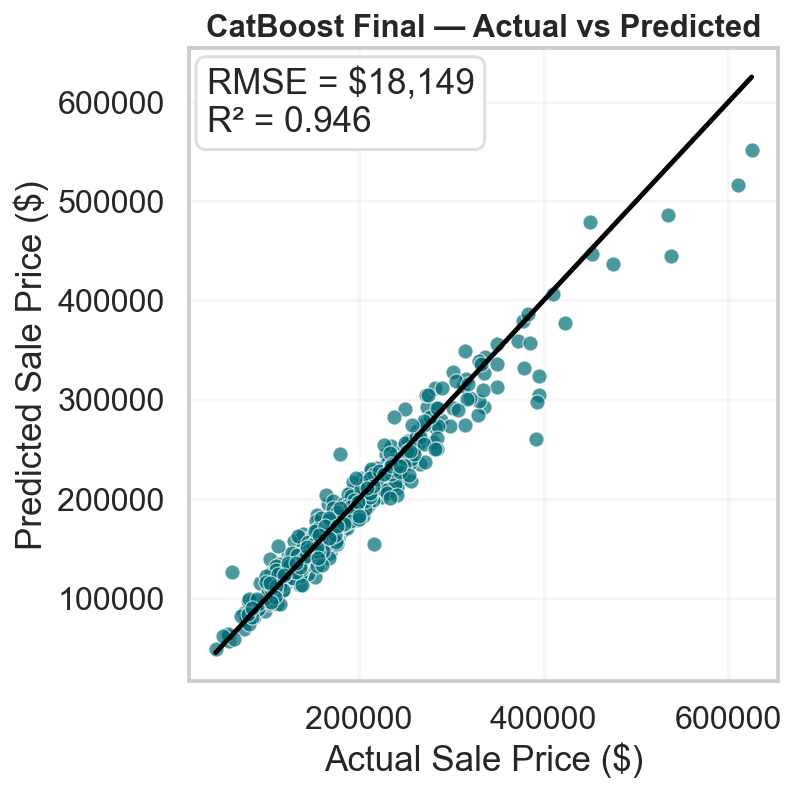

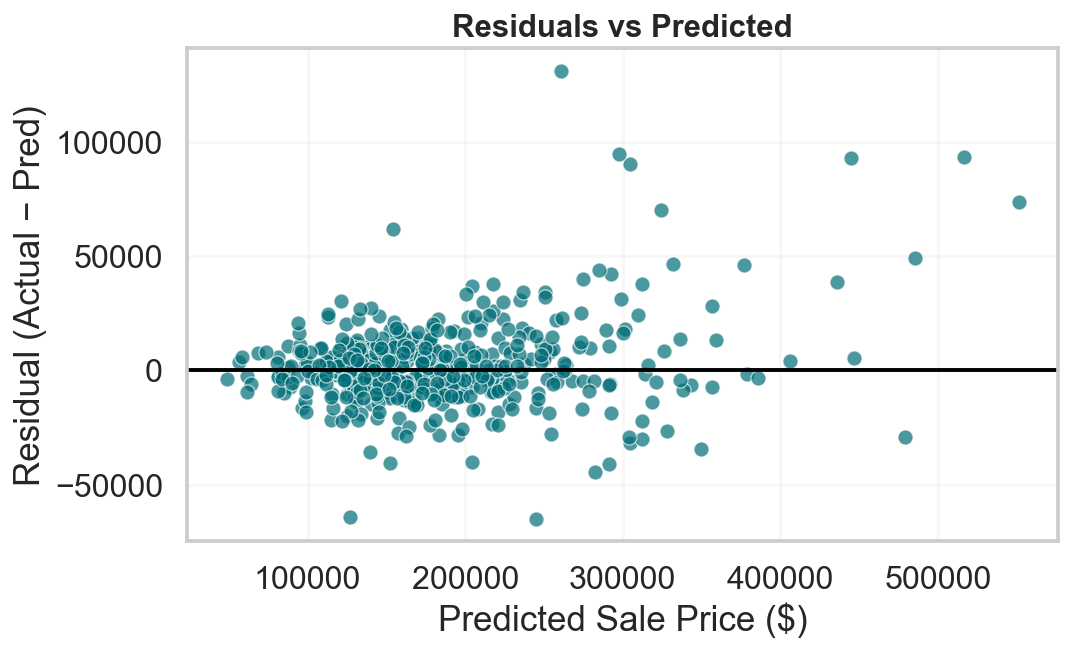

In [105]:
# Warwick colors
warwick_teal   = "#006d77"
warwick_accent = "#83c5be"

sns.set_style("whitegrid")
sns.set_context("talk")

# 1) Parity (Actual vs Predicted)
plt.figure(figsize=(6,6), dpi=140)
plt.scatter(y_test, y_pred_test, color=warwick_teal, alpha=0.7,
            edgecolor="white", linewidth=0.6, s=60)
lims = [min(y_test.min(), y_pred_test.min()), max(y_test.max(), y_pred_test.max())]
plt.plot(lims, lims, color="black", lw=2.5)
plt.title("CatBoost Final — Actual vs Predicted", fontsize=16, weight="bold")
plt.xlabel("Actual Sale Price ($)")
plt.ylabel("Predicted Sale Price ($)")
# annotate metrics
plt.text(0.03, 0.97, f"RMSE = ${rmse_test:,.0f}\nR² = {r2_test:.3f}",
         transform=plt.gca().transAxes, va="top", ha="left",
         bbox=dict(facecolor="white", edgecolor="#ddd", boxstyle="round,pad=0.3"))
plt.tight_layout()
plt.show()

# 2) Residuals vs Predicted
residuals = y_test - y_pred_test
plt.figure(figsize=(8,5), dpi=140)
plt.scatter(y_pred_test, residuals, color=warwick_teal, alpha=0.7,
            edgecolor="white", linewidth=0.6, s=60)
plt.axhline(0, color="black", lw=2)
plt.title("Residuals vs Predicted", fontsize=16, weight="bold")
plt.xlabel("Predicted Sale Price ($)")
plt.ylabel("Residual (Actual − Pred)")
plt.tight_layout()
plt.show()

Hold-out RMSE: 18,149  |  R²: 0.946

Top 20 feature importances (PredictionValuesChange):


,feature,importance
0,TotalSF_x_Qual,26.459973
1,TotalSF,9.684146
2,GrLivArea,4.130075
3,KitchenQual,4.004320
4,OverallQual,3.867612
5,TotalBaths,3.806537
6,OverallCond,3.354645
7,YearBuilt,2.720895
8,GarageArea,2.340274
9,LotArea,2.339106


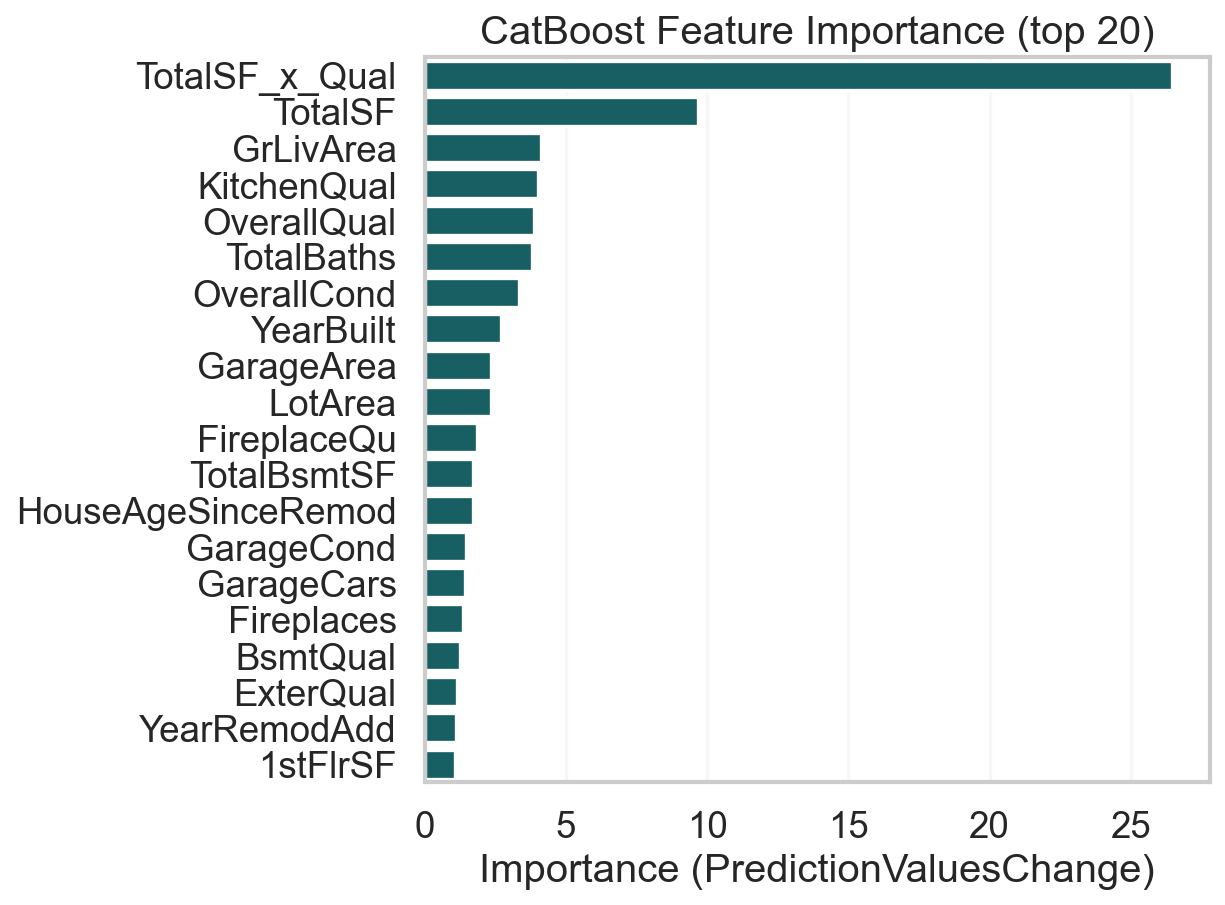


Top 20 by mean |SHAP| on test set:


,feature,mean_abs_shap
0,TotalSF_x_Qual,0.076286
1,TotalSF,0.037744
2,TotalBaths,0.024038
3,GrLivArea,0.023186
4,OverallCond,0.021345
5,LotArea,0.019161
6,KitchenQual,0.017813
7,YearBuilt,0.017556
8,FireplaceQu,0.012708
9,HouseAgeSinceRemod,0.011936


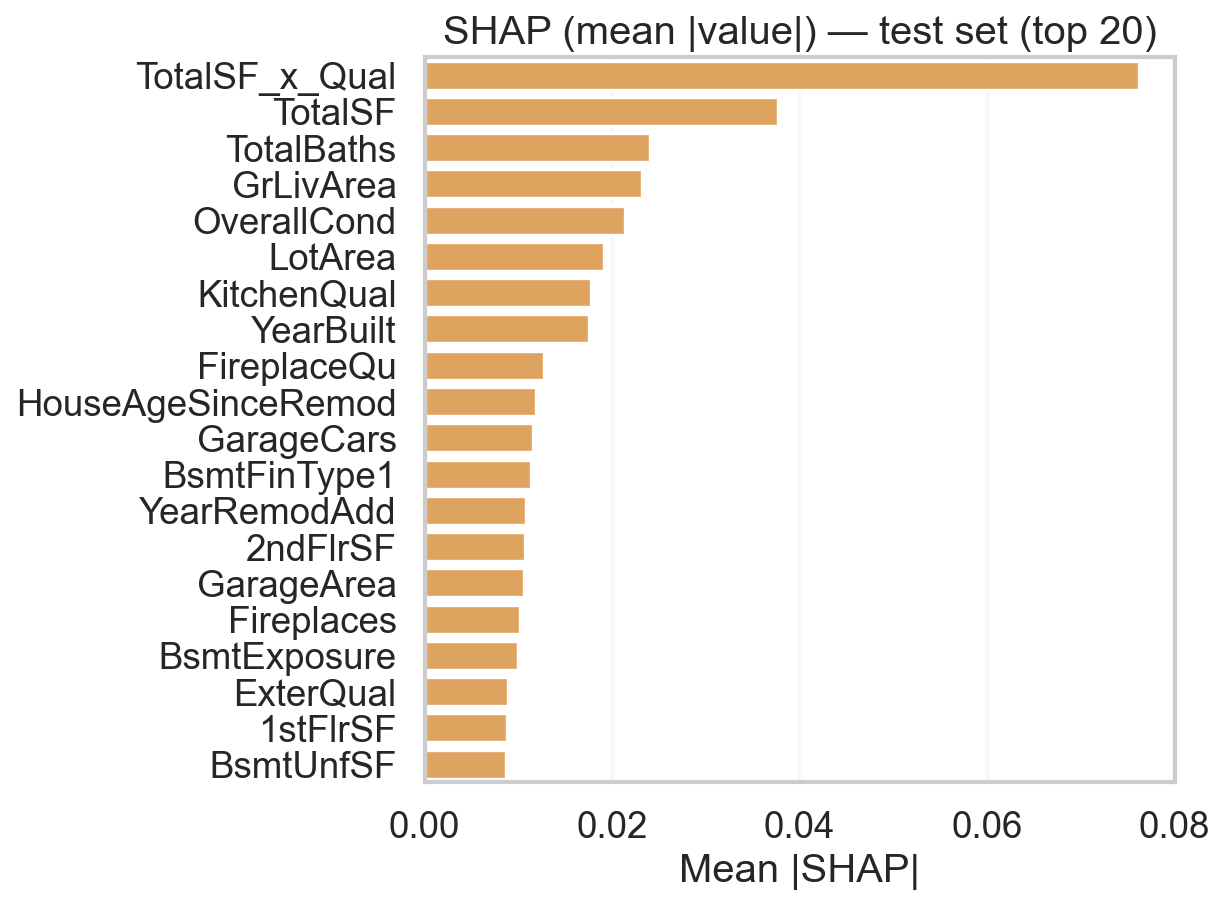

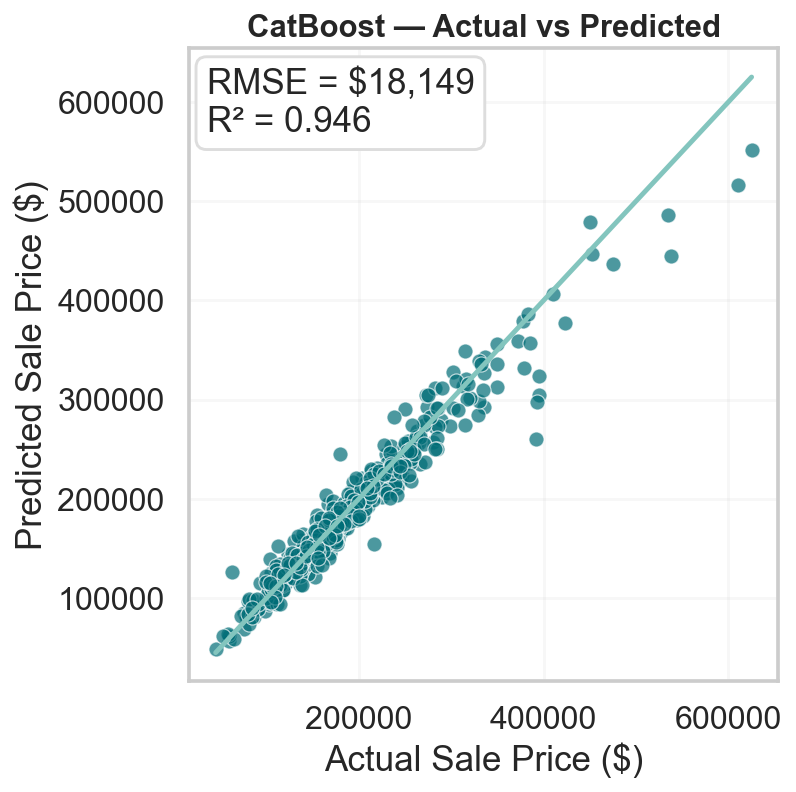

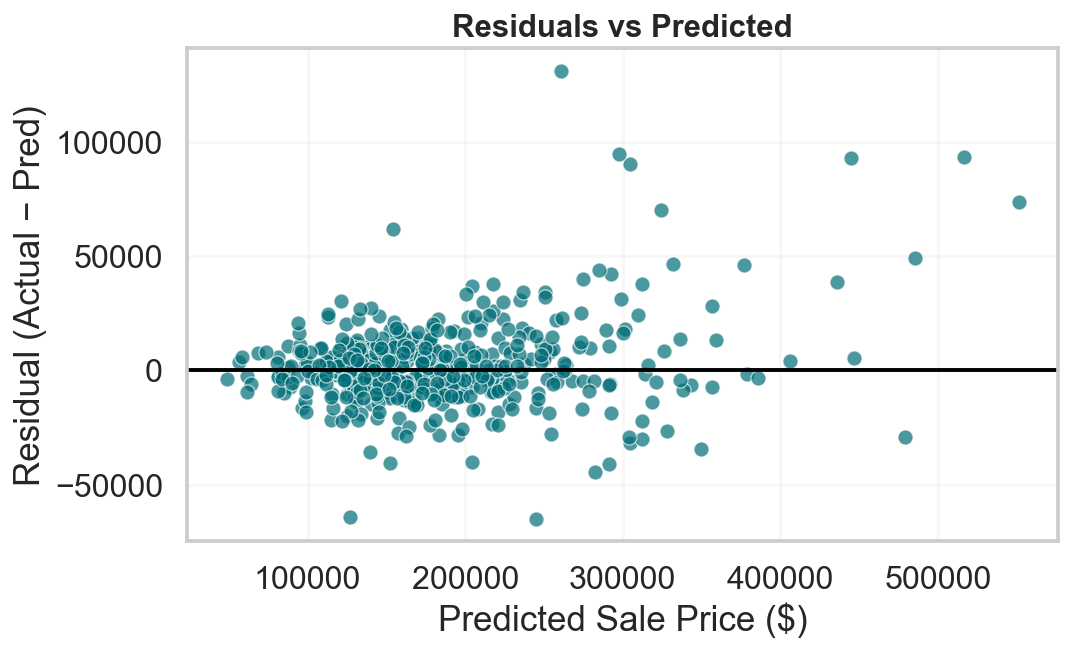

In [106]:
# === Fit → metrics → importances → SHAP (works with your make_catboost_pipe) ===
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from catboost import Pool, CatBoostRegressor

# --- 0) Config / colors
FIG_DPI = 160
COLS = dict(bar="#0B6B6E", shap="#F4A44B")

# If you have best_params from your tuner, keep them here:
best_params = {
    'bagging_temperature': 0.0,
    'colsample_bylevel': 0.5285714285714286,
    'depth': 6,
    'iterations': 7500,
    'l2_leaf_reg': 7.742636826811269,
    'learning_rate': 0.027057333345112382,
    'loss_function': 'RMSE',
    'min_data_in_leaf': 90,
    'random_state': 42,
    'random_strength': 1.3333333333333333,
    'subsample': 0.70,
    'thread_count': -1,
    'verbose': 0,
}

# --- 1) Split & fit (log1p target; CatBoost sees encoded cats via your preprocessor)
X_train, X_test, y_train, y_test = train_test_split(X_fe, y, test_size=0.2, random_state=42)

cb_pipe = make_catboost_pipe(X_fe, **best_params)

# Train on log target
cb_pipe.fit(X_train, np.log1p(y_train))

# Predict (→ dollars)
y_pred_test = np.expm1(cb_pipe.predict(X_test)).astype(float)

from sklearn.metrics import mean_squared_error, r2_score
rmse_test = float(np.sqrt(mean_squared_error(y_test, y_pred_test)))
r2_test   = float(r2_score(y_test, y_pred_test))
print(f"Hold-out RMSE: {rmse_test:,.0f}  |  R²: {r2_test:.3f}")

# --- 2) Get fitted pieces & the exact matrices CatBoost saw
prep     = cb_pipe.named_steps["prep"]          # fitted ColumnTransformer
cb_final = cb_pipe.named_steps["reg"]           # fitted CatBoostRegressor

Xtr_prep = prep.transform(X_train)              # numpy arrays
Xte_prep = prep.transform(X_test)
feat_names = prep.get_feature_names_out()

# --- 3) CatBoost feature importances (PredictionValuesChange)
# Pass a Pool so CatBoost has meta-info and won't error.
ytr_used = np.log1p(y_train).to_numpy(float)
train_pool = Pool(Xtr_prep, label=ytr_used)

imp_arr = cb_final.get_feature_importance(train_pool, type="PredictionValuesChange")
imp_df  = (pd.DataFrame({"feature": feat_names, "importance": imp_arr})
             .sort_values("importance", ascending=False)
             .reset_index(drop=True))

print("\nTop 20 feature importances (PredictionValuesChange):")
display(imp_df.head(20))

# Bar chart (top 20)
topN = 20
plt.figure(figsize=(8, 6), dpi=FIG_DPI)
sns.barplot(
    data=imp_df.head(topN),
    y="feature", x="importance",
    color=COLS["bar"]
)
plt.title("CatBoost Feature Importance (top 20)")
plt.xlabel("Importance (PredictionValuesChange)")
plt.ylabel("")
plt.tight_layout()
plt.show()

# --- 4) SHAP via CatBoost (ShapValues); works on numeric design matrix
# CatBoost returns an (n_samples, n_features+1) matrix; last col is expected value.
shap_mat = cb_final.get_feature_importance(Pool(Xte_prep), type="ShapValues")
shap_vals = shap_mat[:, :-1]            # SHAP per feature
base_val  = shap_mat[:,  -1].mean()     # average expected value (not used in bar)

mean_abs_shap = np.mean(np.abs(shap_vals), axis=0)
shap_df = (pd.DataFrame({"feature": feat_names, "mean_abs_shap": mean_abs_shap})
             .sort_values("mean_abs_shap", ascending=False)
             .reset_index(drop=True))

print("\nTop 20 by mean |SHAP| on test set:")
display(shap_df.head(20))

# SHAP bar (top 20)
plt.figure(figsize=(8, 6), dpi=FIG_DPI)
sns.barplot(
    data=shap_df.head(topN),
    y="feature", x="mean_abs_shap",
    color=COLS["shap"]
)
plt.title("SHAP (mean |value|) — test set (top 20)")
plt.xlabel("Mean |SHAP|")
plt.ylabel("")
plt.tight_layout()
plt.show()

# --- 5) (Optional) One quick parity & residual plot matching your slide style
warwick_teal   = "#006d77"
warwick_accent = "#83c5be"
sns.set_style("whitegrid"); sns.set_context("talk")

# Parity
plt.figure(figsize=(6,6), dpi=140)
plt.scatter(y_test, y_pred_test, color=warwick_teal, alpha=0.7,
            edgecolor="white", linewidth=0.6, s=60)
lims = [min(y_test.min(), y_pred_test.min()), max(y_test.max(), y_pred_test.max())]
plt.plot(lims, lims, color=warwick_accent, lw=2.5)
plt.title("CatBoost — Actual vs Predicted", fontsize=16, weight="bold")
plt.xlabel("Actual Sale Price ($)"); plt.ylabel("Predicted Sale Price ($)")
plt.text(0.03, 0.97, f"RMSE = ${rmse_test:,.0f}\nR² = {r2_test:.3f}",
         transform=plt.gca().transAxes, va="top", ha="left",
         bbox=dict(facecolor="white", edgecolor="#ddd", boxstyle="round,pad=0.3"))
plt.tight_layout(); plt.show()

# Residuals
residuals = y_test.to_numpy(float) - y_pred_test
plt.figure(figsize=(8,5), dpi=140)
plt.scatter(y_pred_test, residuals, color=warwick_teal, alpha=0.7,
            edgecolor="white", linewidth=0.6, s=60)
plt.axhline(0, color="black", lw=2)
plt.title("Residuals vs Predicted", fontsize=16, weight="bold")
plt.xlabel("Predicted Sale Price ($)"); plt.ylabel("Residual (Actual − Pred)")
plt.tight_layout(); plt.show()

In [107]:
# --- Upgrades list (your list) ---
UPGRADES = [
    {"feature": "ExterQual",   "to": "best", "upgrade": "ExterQual → best (max)"},
    {"feature": "KitchenQual", "to": "best", "upgrade": "KitchenQual → best (max)"},
    {"feature": "ExterQual",   "step": +1,   "upgrade": "ExterQual +1 step"},
    {"feature": "KitchenQual", "step": +1,   "upgrade": "KitchenQual +1 step"},
    {"feature": "GarageCars",  "delta": +1.0,  "upgrade": "GarageCars +1.0"},
    {"feature": "TotalBaths",  "delta": +1.0,  "upgrade": "TotalBaths +1.0"},
    {"feature": "TotalSF",     "delta": +200., "upgrade": "TotalSF +200.0"},
    {"feature": "WoodDeckSF",  "delta": +100., "upgrade": "WoodDeckSF +100.0"},
    {"feature": "GarageArea",  "delta": +100., "upgrade": "GarageArea +100.0"},
    {"feature": "OpenPorchSF", "delta": +50.,  "upgrade": "OpenPorchSF +50.0"},
    {"feature": "ScreenPorch", "delta": +50.,  "upgrade": "ScreenPorch +50.0"},
    {"feature": "EnclosedPorch","delta": +50., "upgrade": "EnclosedPorch +50.0"},
]

# --- small helpers for categorical steps ---
def step_ordinal_series(s: pd.Series, order: list[str], step: int) -> pd.Series:
    cat = pd.Categorical(s, categories=order, ordered=True)
    codes = cat.codes
    valid = codes >= 0
    new_codes = codes.copy()
    new_codes[valid] = np.clip(new_codes[valid] + step, 0, len(order)-1)
    out = pd.Series(pd.Categorical.from_codes(new_codes, categories=order, ordered=True), index=s.index)
    return out.astype(object)

def to_best_series(s: pd.Series, order: list[str]) -> pd.Series:
    top = order[-1]
    out = s.copy()
    out.loc[s.notna()] = top
    return out.astype(object)

In [261]:
# --- Helpers that keep categorical dtype intact ---
def _step_ordinal_series(s: pd.Series, order: list[str], step: int) -> pd.Series:
    cat = pd.Categorical(s, categories=order, ordered=True)
    codes = cat.codes
    valid = codes >= 0
    new_codes = codes.copy()
    new_codes[valid] = np.clip(new_codes[valid] + step, 0, len(order)-1)
    out = pd.Series(pd.Categorical.from_codes(new_codes, categories=order, ordered=True), index=s.index)
    return out.astype(object)

def _to_best_series(s: pd.Series, order: list[str]) -> pd.Series:
    top = order[-1]
    out = s.copy()
    out.loc[s.notna()] = top
    return out.astype(object)

def _predict_dollars_pipe(cb_pipe, X: pd.DataFrame, target_log=True) -> np.ndarray:
    raw = cb_pipe.predict(X).astype(float)
    return np.expm1(raw) if target_log else raw

# --- Simulator that ONLY uses the fitted pipeline ---
def simulate_upgrades_fast_pipe(
    cb_pipe,                    # your fitted Pipeline([... ("prep", ...), ("reg", CatBoostRegressor)])
    base_df: pd.DataFrame,      # your OOF table with cols at least: _idx, _id_, y_true, base_pred, residual/resid_clipped
    X: pd.DataFrame,            # original feature frame (same schema used to fit cb_pipe)
    upgrades=UPGRADES,
    *,
    residual_col: str = "resid_clipped",   # or "residual" if you prefer raw OOF
    outlier_col: str | None = "is_outlier",
    drop_outliers: bool = False,           # default: keep; we only label
    top_frac: float = 0.30,
    target_log: bool = True
) -> tuple[pd.DataFrame, pd.DataFrame]:

    need_cols = {"_idx","_id_","y_true","base_pred"}
    if residual_col not in base_df.columns:
        raise KeyError(f"base_df must contain '{residual_col}'. Available: {list(base_df.columns)}")
    if not need_cols.issubset(base_df.columns):
        missing = need_cols - set(base_df.columns)
        raise KeyError(f"base_df is missing required columns: {missing}")

    # Start from a copy; optionally exclude outliers from the ranking pool
    work = base_df.copy()
    if drop_outliers and (outlier_col is not None) and (outlier_col in work.columns):
        work = work.loc[~work[outlier_col].astype(bool)].copy()

    # Select top-k underpriced by the chosen residual column
    k = max(1, int(round(top_frac * len(work))))
    under = (
        work.nlargest(k, residual_col)        # largest positive residuals
            .loc[:, ["_idx","_id_","y_true","base_pred", residual_col]]
            .rename(columns={residual_col: "residual"})
            .copy()
    )

    # Keep the outlier flag for reference (even if not used for filtering)
    if (outlier_col is not None) and (outlier_col in base_df.columns):
        under = under.merge(base_df[["_idx", outlier_col]], on="_idx", how="left")

    # Build upgrade variants for the selected subset
    idxs = under["_idx"].to_numpy()
    X_slice = X.iloc[idxs].copy()

    combos = []
    for upg in upgrades:
        f = upg["feature"]
        if f not in X_slice.columns:
            continue
        X_mod = X_slice.copy()

        if "delta" in upg:
            X_mod[f] = pd.to_numeric(X_mod[f], errors="coerce") + upg["delta"]
        elif "step" in upg:
            order = ORDINAL_ORDER.get(f)
            if order is None:
                continue
            X_mod[f] = _step_ordinal_series(X_mod[f], order, upg["step"])
        elif upg.get("to") == "best":
            order = ORDINAL_ORDER.get(f)
            if order is None:
                continue
            X_mod[f] = _to_best_series(X_mod[f], order)
        else:
            continue

        combos.append((upg["upgrade"], f, X_mod))

    if not combos:
        # Safe empty outputs if none of the requested features exist
        out = under.copy()
        out["best_upgrade"] = np.nan
        out["best_feature"] = np.nan
        out["best_new_pred"] = out["base_pred"]
        out["best_uplift"]   = 0.0
        out["residual_source"] = residual_col
        return out, pd.DataFrame(columns=[])

    # Bulk predict via the pipeline (no CatBoost Pool here)
    big = pd.concat([df for _,_,df in combos], axis=0, ignore_index=False)
    rep_names    = np.concatenate([np.full(len(df), name, dtype=object) for name,_,df in combos])
    rep_features = np.concatenate([np.full(len(df), feat, dtype=object) for _,feat,df in combos])

    pred_all = _predict_dollars_pipe(cb_pipe, big, target_log=target_log)

    # Assemble long table aligned with 'under'
    repeated_keys = np.tile(under[["_idx","_id_","base_pred","y_true","residual"]].to_numpy(), (len(combos), 1))
    upgrades_long = pd.DataFrame({
        "_idx":       repeated_keys[:,0].astype(int),
        "_id_":       repeated_keys[:,1],
        "base_pred":  repeated_keys[:,2].astype(float),
        "y_true":     repeated_keys[:,3].astype(float),
        "residual":   repeated_keys[:,4].astype(float),
        "upgrade":    rep_names,
        "feature":    rep_features,
        "new_pred":   pred_all.astype(float),
    })
    upgrades_long["uplift"] = upgrades_long["new_pred"] - upgrades_long["base_pred"]

    # Best per home
    best_per_home = (
        upgrades_long.sort_values(["_idx","uplift"], ascending=[True, False])
                     .groupby("_idx", as_index=False)
                     .first()
                     .drop(columns=["base_pred","y_true","residual"], errors="ignore")
                     .rename(columns={
                         "upgrade":"best_upgrade",
                         "feature":"best_feature",
                         "new_pred":"best_new_pred",
                         "uplift":"best_uplift"
                     })
    )

    candidates = under.merge(best_per_home, on="_idx", how="left")
    candidates["residual_source"] = residual_col

    # Friendly sort
    sort_cols = [c for c in ["residual","best_uplift"] if c in candidates.columns]
    if sort_cols:
        candidates = candidates.sort_values(sort_cols, ascending=[False]*len(sort_cols), ignore_index=True)

    return candidates, upgrades_long

In [263]:
# Use your already-fitted pipeline (cb_pipe), the OOF table you built earlier, and X_fe
candidates_summary, upgrades_long_ctx = simulate_upgrades_fast_pipe(
    cb_pipe=cb_pipe,
    base_df=base_df_oof,          # has resid_clipped and is_outlier
    X=X_fe,
    upgrades=UPGRADES,
    residual_col="resid_clipped", # <- use the clipped OOF residuals for ranking
    outlier_col="is_outlier",     # <- keep the flag
    drop_outliers=False,          # <- do NOT drop; just label them
    top_frac=0.30,
    target_log=True               # because you trained on log1p(y)
)

print("Candidates:", candidates_summary.shape, "| Upgrades long:", upgrades_long_ctx.shape)
print(candidates_summary.head(3))

Candidates: (774, 12) | Upgrades long: (9288, 9)
   _idx  _id__x    y_true      base_pred      residual  is_outlier  _id__y  \
0  1007       8  755000.0  546508.252996  58486.043428        True     8.0   
1   615     616  591587.0  451611.270889  58486.043428        True   616.0   
2  2004     188  475000.0  347467.969054  58486.043428        True   188.0   

               best_upgrade best_feature  best_new_pred    best_uplift  \
0    ExterQual → best (max)    ExterQual  753570.305737  207062.052741   
1  KitchenQual → best (max)  KitchenQual  607705.700291  156094.429403   
2           TotalBaths +1.0   TotalBaths  480513.705757  133045.736704   

  residual_source  
0   resid_clipped  
1   resid_clipped  
2   resid_clipped  


In [271]:
import numpy as np
import pandas as pd

# ---------- helpers ----------
def _coerce_float(x, default=0.0):
    try:
        v = float(x)
        if np.isnan(v):
            return default
        return v
    except Exception:
        return default

def _apply_upgrade_scalar(value, upg, order=None):
    """Return upgraded scalar for one feature."""
    if "delta" in upg:                       # numeric bump
        return _coerce_float(value) + float(upg["delta"])
    if "step" in upg and order is not None:  # ordinal step
        try:
            i = order.index(str(value)) if not isinstance(value, str) else order.index(value)
        except ValueError:
            # unseen label -> treat as worst (index 0)
            i = 0
        j = int(np.clip(i + int(upg["step"]), 0, len(order)-1))
        return order[j]
    if upg.get("to") == "best" and order is not None:
        return order[-1]
    return value

def _apply_upgrade_to_row(row: pd.Series, upg: dict, ORDINAL_ORDER: dict) -> pd.Series:
    r = row.copy()
    f = upg["feature"]
    if f not in r.index:
        return r
    order = ORDINAL_ORDER.get(f)
    r.at[f] = _apply_upgrade_scalar(r.at[f], upg, order=order)
    return r

def _predict_dollars_pipe(cb_pipe, X_df: pd.DataFrame, *, model_outputs_log=False) -> np.ndarray:
    raw = cb_pipe.predict(X_df).astype(float)
    return np.expm1(raw) if model_outputs_log else raw

# optional constraint system (you can keep them empty if you want everything combinable)
def _allowed_with(current_feats: set[str], new_feat: str, MUTEX_GROUPS: list[set[str]], ALLOWED_PAIRS: set[tuple[str,str]]) -> bool:
    # allow exact pair exceptions
    for f in current_feats:
        if (f, new_feat) in ALLOWED_PAIRS or (new_feat, f) in ALLOWED_PAIRS:
            return True
    # block mutex violations
    for g in MUTEX_GROUPS:
        if new_feat in g and any(f in g for f in current_feats):
            return False
    return True

# ---------- main entrypoint ----------
def compute_candidates_and_upgrades_pipe(
    *,
    cb_pipe,
    X_fe: pd.DataFrame,
    base_df_oof: pd.DataFrame,
    ORDINAL_ORDER: dict,
    upgrades: list[dict],
    residual_col: str = "residual",          # or "resid_clipped"
    outlier_col: str | None = "is_outlier",
    drop_outliers: bool = False,
    top_frac: float = 0.30,
    model_outputs_log: bool = False,         # your pipeline outputs $ by default, so False
    max_features_in_stack: int = 4,
    require_positive_marginal: bool = True,
    MUTEX_GROUPS: list[set[str]] = None,
    ALLOWED_PAIRS: set[tuple[str,str]] = None,
    feature_cols_to_attach: list[str] | None = None,
):
    MUTEX_GROUPS = MUTEX_GROUPS or []
    ALLOWED_PAIRS = ALLOWED_PAIRS or set()

    # --- prep: indexable feature frame by _idx ---
    X_work = X_fe.copy()
    if "_idx" not in X_work.columns:
        X_work["_idx"] = np.arange(len(X_work), dtype=int)
    X_work = X_work.set_index("_idx", drop=False)

    # --- OOF table sanity & selection ---
    need = {"_idx", "y_true", "base_pred", residual_col}
    missing = need - set(base_df_oof.columns)
    if missing:
        raise KeyError(f"base_df_oof missing {missing}")

    pool = base_df_oof.copy()
    if drop_outliers and outlier_col and outlier_col in pool.columns:
        pool = pool.loc[~pool[outlier_col].astype(bool)].copy()

    k = max(1, int(round(top_frac * len(pool))))
    under = (
        pool.nlargest(k, residual_col)[["_idx", "y_true", "base_pred", residual_col]]
            .rename(columns={residual_col: "residual"})
            .copy()
    )
    if outlier_col and outlier_col in base_df_oof.columns:
        under = under.merge(base_df_oof[["_idx", outlier_col]], on="_idx", how="left")

    base_lookup = pool.set_index("_idx")["base_pred"]

    # --- evaluate upgrades (singles + greedy stack) per home ---
    records = []
    long_rows = []

    feat_cols_full = X_work.columns.tolist()

    for idx in under["_idx"].tolist():
        if idx not in X_work.index:
            continue
        x0 = X_work.loc[idx, :]
        base_pred = float(base_lookup.loc[idx])

        # singles
        single_best = None  # (uplift, upg, new_pred)
        singles_for_sort = []

        for upg in upgrades:
            f = upg["feature"]
            if f not in x0.index:
                continue
            x1 = _apply_upgrade_to_row(x0, upg, ORDINAL_ORDER)
            pred1 = float(_predict_dollars_pipe(cb_pipe, pd.DataFrame([x1.values], columns=feat_cols_full), model_outputs_log=model_outputs_log)[0])
            uplift1 = pred1 - base_pred

            singles_for_sort.append((uplift1, upg, pred1))
            long_rows.append({
                "_idx": idx,
                "upgrade": upg["upgrade"],
                "feature": f,
                "new_pred": pred1,
                "base_pred": base_pred,
                "uplift": uplift1
            })

        if not singles_for_sort:
            # no applicable upgrades — keep baseline
            records.append({
                "_idx": idx,
                "y_true": float(under.loc[under["_idx"]==idx, "y_true"]),
                "residual": float(under.loc[under["_idx"]==idx, "residual"]),
                "best_upgrade": np.nan,
                "best_feature": np.nan,
                "best_new_pred": base_pred,
                "best_uplift": 0.0,
                "best_uplift_pct": 0.0,
                "stacked_combo": [],
                "stacked_new_pred": base_pred,
                "stacked_uplift": 0.0,
                "stacked_uplift_pct": 0.0
            })
            continue

        singles_for_sort.sort(key=lambda t: t[0], reverse=True)
        best_uplift, best_upg, best_pred = singles_for_sort[0]

        # --- greedy stack starts with the best single ---
        applied = [best_upg["upgrade"]]
        applied_feats = {best_upg["feature"]}
        cur_pred = best_pred
        cur_row = _apply_upgrade_to_row(x0, best_upg, ORDINAL_ORDER)

        # candidates to try next: by descending single uplift (fast heuristic)
        for uplift1, upg, _ in singles_for_sort[1:]:
            if len(applied_feats) >= max_features_in_stack:
                break
            f = upg["feature"]
            if f in applied_feats:
                continue
            if not _allowed_with(applied_feats, f, MUTEX_GROUPS, ALLOWED_PAIRS):
                continue

            # marginal improvement from current state
            x2 = _apply_upgrade_to_row(cur_row, upg, ORDINAL_ORDER)
            pred2 = float(_predict_dollars_pipe(cb_pipe, pd.DataFrame([x2.values], columns=feat_cols_full), model_outputs_log=model_outputs_log)[0])
            marginal = pred2 - cur_pred
            if require_positive_marginal and marginal <= 0:
                continue

            # accept
            applied.append(upg["upgrade"])
            applied_feats.add(f)
            cur_pred = pred2
            cur_row = x2

            if len(applied_feats) >= max_features_in_stack:
                break

        stacked_new_pred = cur_pred
        stacked_uplift = stacked_new_pred - base_pred
        # guard: stacked should not underperform best
        if stacked_uplift < best_uplift:
            stacked_new_pred = best_pred
            stacked_uplift = best_uplift
            applied = [best_upg["upgrade"]]

        records.append({
            "_idx": idx,
            "y_true": float(under.loc[under["_idx"]==idx, "y_true"]),
            "residual": float(under.loc[under["_idx"]==idx, "residual"]),
            "best_upgrade": best_upg["upgrade"],
            "best_feature": best_upg["feature"],
            "best_new_pred": best_pred,
            "best_uplift": best_uplift,
            "best_uplift_pct": (best_uplift / base_pred) if base_pred > 0 else np.nan,
            "stacked_combo": applied,
            "stacked_new_pred": stacked_new_pred,
            "stacked_uplift": stacked_uplift,
            "stacked_uplift_pct": (stacked_uplift / base_pred) if base_pred > 0 else np.nan,
        })

    candidates = pd.DataFrame.from_records(records)

    # attach outlier flag if present
    if outlier_col and outlier_col in under.columns:
        candidates = candidates.merge(under[["_idx", outlier_col]], on="_idx", how="left")

    # attach optional descriptive features (clean, no suffixes)
    if feature_cols_to_attach:
        attach = X_work[["_idx", *[c for c in feature_cols_to_attach if c in X_work.columns]]].copy()
        candidates = candidates.merge(attach, on="_idx", how="left")

    upgrades_long_ctx = pd.DataFrame(long_rows)
    return candidates, upgrades_long_ctx

In [272]:
FEAT_COLS = [
    "Neighborhood","MSZoning","KitchenQual","ExterQual",
    "OverallQual","GrLivArea","TotalBaths","GarageArea",
    "TotalSF","YearBuilt","YearRemodAdd","LotArea"
]

# No mutex by default; allow any combos (you can add rules later)
MUTEX = []
ALLOWED = set()

candidates_summary, upgrades_long_ctx = compute_candidates_and_upgrades_pipe(
    cb_pipe=cb_pipe,                      # your fitted pipeline
    X_fe=X_fe,                            # engineered features
    base_df_oof=base_df_oof,              # OOF table with _idx, y_true, base_pred, residual
    ORDINAL_ORDER=ORDINAL_ORDER,
    upgrades=UPGRADES,
    residual_col="residual",              # you concluded raw residual is fine
    drop_outliers=False,                  # keep; you can filter later
    top_frac=0.30,                        # top 30% underpriced pool
    model_outputs_log=False,              # your pipe predicts $ directly
    max_features_in_stack=4,
    require_positive_marginal=True,
    MUTEX_GROUPS=MUTEX,
    ALLOWED_PAIRS=ALLOWED,
    feature_cols_to_attach=FEAT_COLS
)

# sanity: stacked should dominate best
viol = (candidates_summary["stacked_uplift"] + 1e-9) < candidates_summary["best_uplift"]
print("Violations where stacked < best:", int(viol.sum()))

ValueError: '_idx' is both an index level and a column label, which is ambiguous.

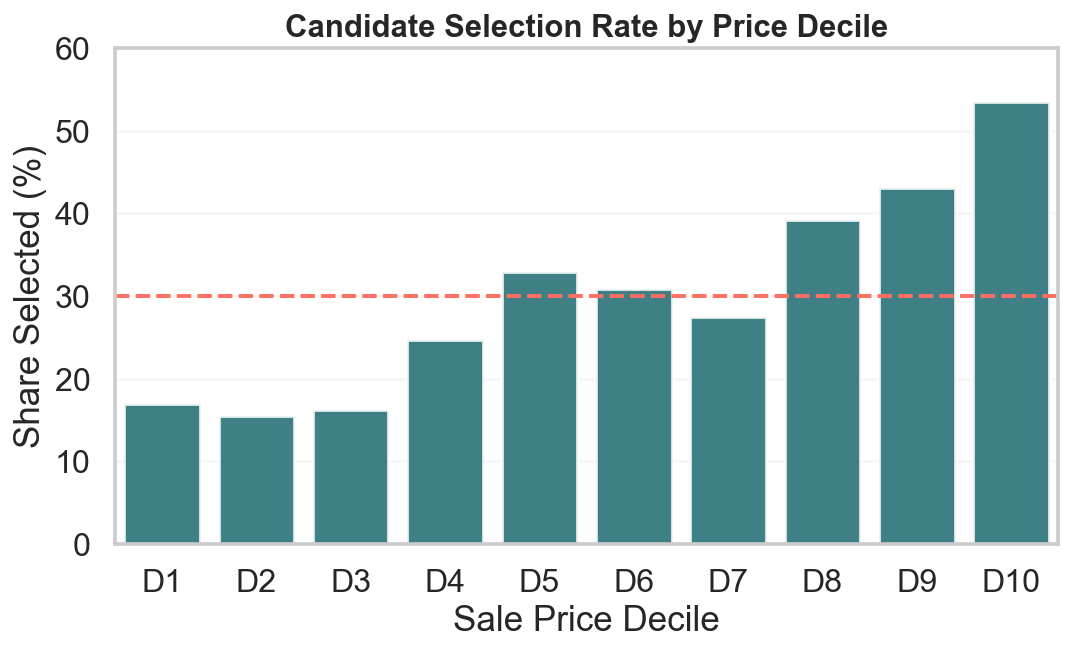

In [124]:
# --- Decile selection chart (clean version) ---
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# assign deciles
all_prices = base_df_oof["y_true"]
mask_candidates = base_df_oof["_idx"].isin(candidates_summary["_idx"])
base_df_oof["decile"] = pd.qcut(all_prices, 10, labels=[f"D{i}" for i in range(1,11)])

# selection rate per decile
decile_rates = (
    base_df_oof.groupby("decile")["_idx"]
    .apply(lambda idx: idx.isin(candidates_summary["_idx"]).mean() * 100)
)

# plot
plt.figure(figsize=(8,5), dpi=140)
sns.barplot(x=decile_rates.index, y=decile_rates.values, color="#006d77", alpha=0.8)

# baseline 30%
plt.axhline(30, color="#ff6f61", lw=2, linestyle="--", label="Expected (30%)")

plt.title("Candidate Selection Rate by Price Decile", fontsize=16, weight="bold")
plt.xlabel("Sale Price Decile")
plt.ylabel("Share Selected (%)")
plt.ylim(0, 60)
# plt.legend(frameon=False)
plt.tight_layout()
plt.show()

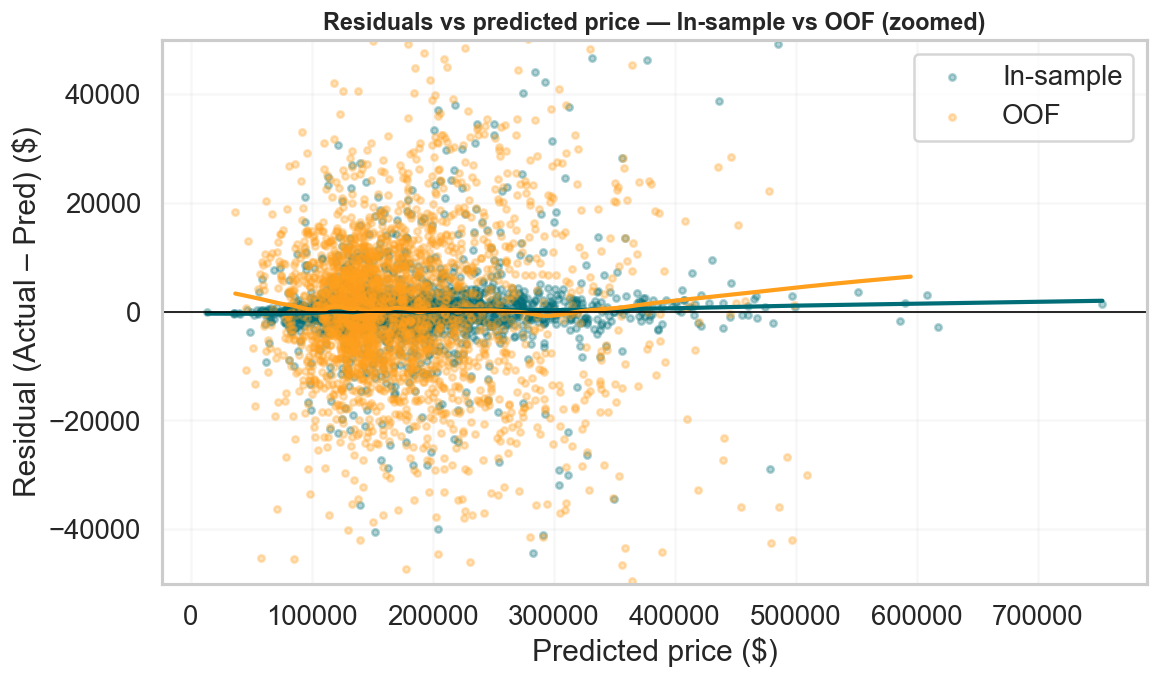

In [140]:
# Zoomed residual plot
plt.figure(figsize=(10,6), dpi=120)

plt.scatter(y_pred_insample, resid_insample, s=15, alpha=0.3,
            color="#006d77", label="In-sample")
plt.scatter(pred_oof, resid_oof, s=15, alpha=0.3,
            color="#ff9f1c", label="OOF")

# LOWESS smoothers
smooth_in  = sm.nonparametric.lowess(resid_insample, y_pred_insample, frac=0.2)
smooth_oof = sm.nonparametric.lowess(resid_oof, pred_oof, frac=0.2)
plt.plot(smooth_in[:,0], smooth_in[:,1], color="#006d77", lw=2.5)
plt.plot(smooth_oof[:,0], smooth_oof[:,1], color="#ff9f1c", lw=2.5)

plt.axhline(0, color="black", lw=1)
plt.ylim(-50000, 50000)  # zoom in to ±50k
plt.title("Residuals vs predicted price — In-sample vs OOF (zoomed)", fontsize=14, weight="bold")
plt.xlabel("Predicted price ($)")
plt.ylabel("Residual (Actual – Pred) ($)")
plt.legend()
plt.tight_layout()
plt.show()

In [147]:
def select_top_candidates(
    cand,
    top_pct=0.10,
    by="best_uplift",
    drop_outliers=False,
    outlier_col="is_outlier"
):
    """
    Select top candidates by uplift (or another metric).
    
    Args:
        cand: candidates_summary DataFrame.
        top_pct: fraction to select (0–1).
        by: column name to rank by (default: 'best_uplift').
        drop_outliers: if True, filter out flagged outliers before ranking.
        outlier_col: column name marking outliers (default: 'is_outlier').

    Returns:
        DataFrame of top candidates, with a flag 'outliers_included'.
    """
    assert by in cand.columns, f"{by} not in candidates"

    # Optionally drop outliers
    df = cand.copy()
    if drop_outliers and outlier_col in df.columns:
        df = df.loc[~df[outlier_col]]

    # How many to keep
    n = max(1, int(round(len(df) * top_pct)))

    # Select top-N
    top = df.sort_values(by, ascending=False).head(n).copy()
    
    return top

In [157]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_decile_distribution(df_all, df_top, price_col="y_true", title="Top ripest by price decile"):
    """
    Compare distribution of selected top candidates against all homes by price decile.

    Args:
        df_all: DataFrame with all candidate homes (must include price_col).
        df_top: DataFrame with subset (e.g., top_ripest).
        price_col: column containing sale price (default 'y_true').
        title: chart title.
    """
    # Assign deciles on the full candidate set
    all_prices = df_all[price_col]
    deciles = pd.qcut(all_prices, 10, labels=[f"D{i}" for i in range(1, 11)])
    df_all = df_all.copy()
    df_all["decile"] = deciles
    df_top = df_top.copy()
    df_top["decile"] = pd.qcut(all_prices, 10, labels=[f"D{i}" for i in range(1, 11)]).loc[df_top.index]

    # Compute share within each decile
    top_counts = df_top["decile"].value_counts(normalize=True).sort_index() * 100

    # Plot
    plt.figure(figsize=(9,5), dpi=130)
    top_counts.plot(kind="bar", color="teal", edgecolor="black")
    plt.axhline(10, color="gray", linestyle="--")  # baseline if perfectly even
    plt.ylabel("Share of top candidates (%)")
    plt.xlabel("Price decile (D1 = cheapest … D10 = most expensive)")
    plt.title(title)
    plt.ylim(0, top_counts.max() * 1.2)
    plt.show()



In [204]:
# Columns you want back on candidates_summary
FEAT_COLS = [
    "Neighborhood","MSZoning","KitchenQual","ExterQual",
    "OverallQual","GrLivArea","TotalBaths","GarageArea",
    "TotalSF","YearBuilt","YearRemodAdd","LotArea"
]

# Make an indexable copy of your feature frame
fe = X_fe.copy()
fe["_idx"] = np.arange(len(fe), dtype=int)

# Only add features that are present in X_fe AND not already on candidates_summary
cols_to_add = [c for c in FEAT_COLS
               if c in fe.columns and c not in candidates_summary.columns]

if cols_to_add:
    fe_slim = fe[["_idx", *cols_to_add]]
    candidates_summary = candidates_summary.merge(fe_slim, on="_idx", how="left")
else:
    print("Nothing to add — all requested feature columns already exist on candidates_summary.")

Nothing to add — all requested feature columns already exist on candidates_summary.


In [205]:
candidates_summary.columns

Index(['_idx', '_id__x', 'y_true', 'base_pred', 'residual', 'is_outlier',
       '_id__y', 'best_upgrade', 'best_feature', 'best_new_pred',
       'best_uplift', 'residual_source', 'Neighborhood', 'MSZoning',
       'KitchenQual', 'ExterQual', 'OverallQual', 'GrLivArea', 'TotalBaths',
       'GarageArea', 'TotalSF', 'YearBuilt', 'YearRemodAdd', 'LotArea'],
      dtype='object')

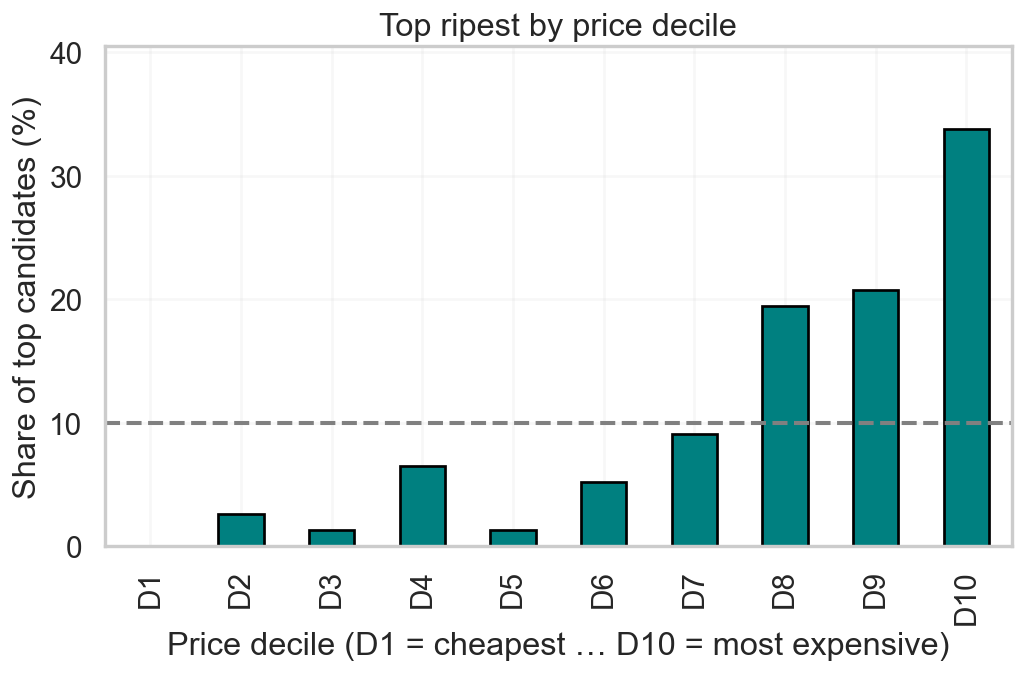

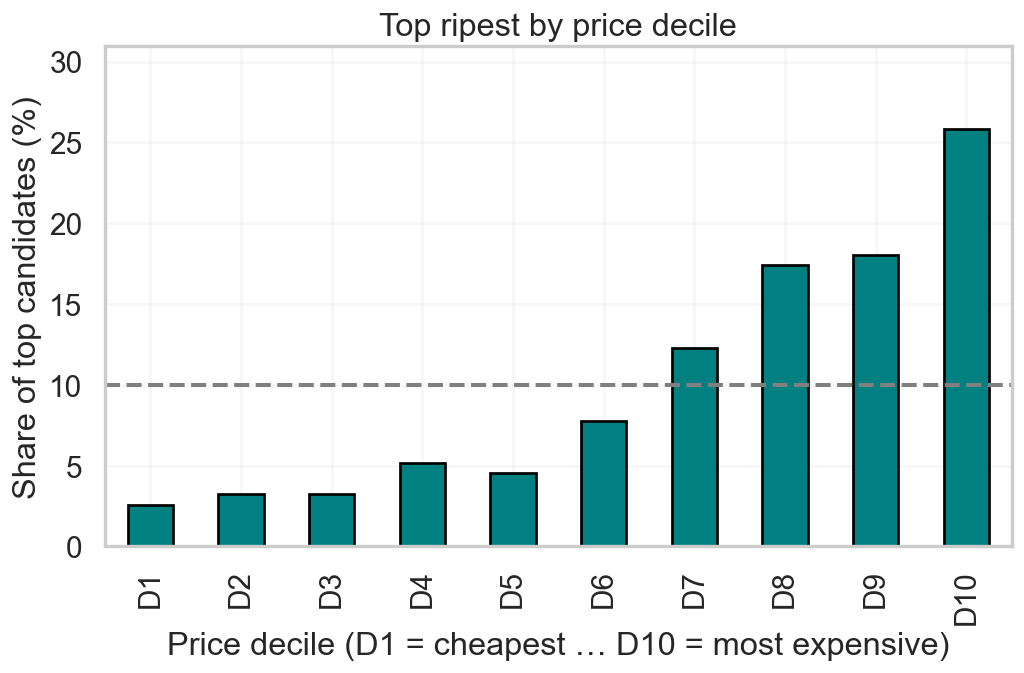

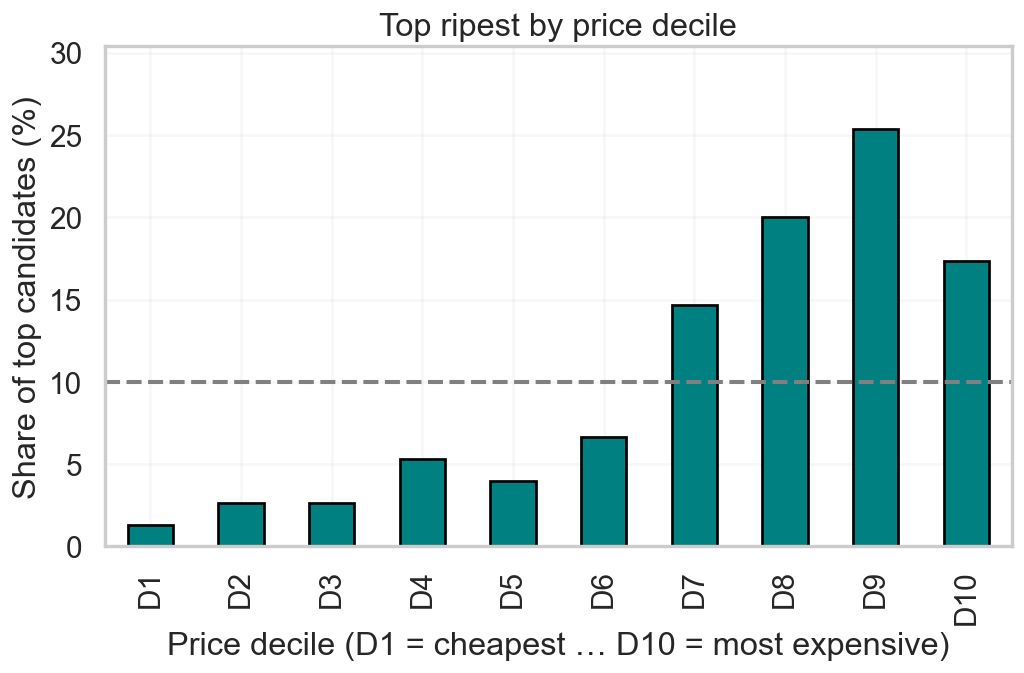

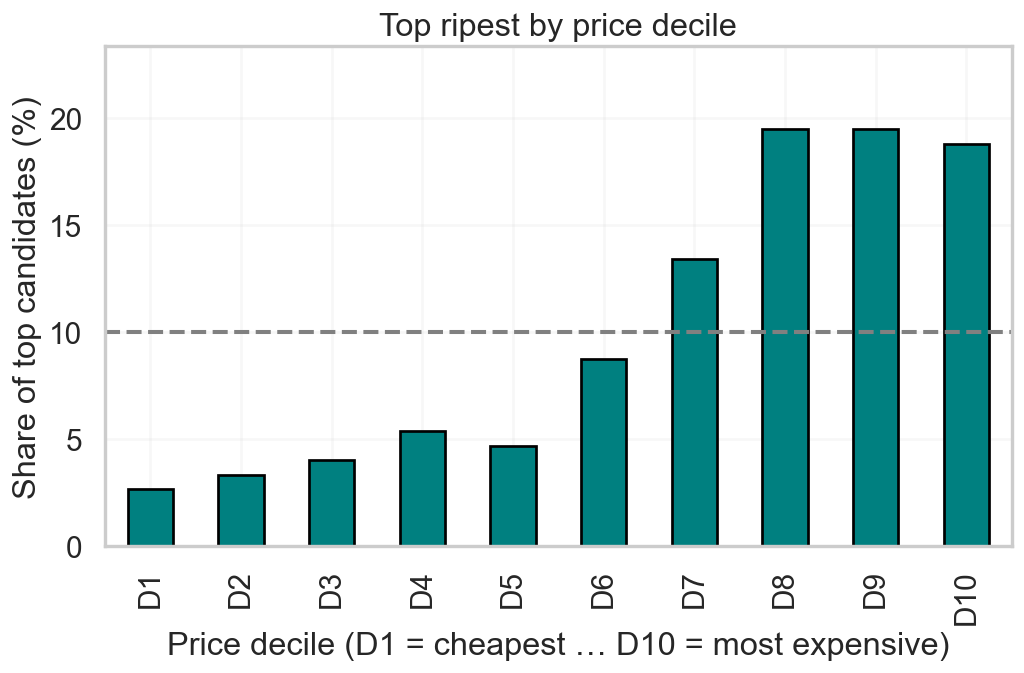

In [188]:

top_ripest_with_10 = select_top_candidates(candidates_summary, top_pct=0.10, drop_outliers=False)
top_ripest_with_20 = select_top_candidates(candidates_summary, top_pct=0.20, drop_outliers=False)
top_ripest_without_10 = select_top_candidates(candidates_summary, top_pct=0.10, drop_outliers=True)
top_ripest_without_20 = select_top_candidates(candidates_summary, top_pct=0.20, drop_outliers=True)

plot_decile_distribution(candidates_summary, top_ripest_with_10)
plot_decile_distribution(candidates_summary, top_ripest_with_20)
plot_decile_distribution(candidates_summary, top_ripest_without_10)
plot_decile_distribution(candidates_summary, top_ripest_without_20)


In [190]:
from scipy.stats import ttest_ind

def compare_top_vs_rest(universe_df, top_df, numeric_cols, key="_idx", year_features=("YearBuilt","YearRemodAdd")):
    """
    Compare numeric features between top candidates and the rest of the candidate pool.
    
    - `universe_df`: full candidate pool (e.g., candidates_summary)
    - `top_df`: subset (e.g., top_ripest_with_10)
    - `numeric_cols`: list of numeric features to compare
    - `key`: join key (default: "_idx")
    - `year_features`: features where diff is absolute instead of percentage
    """
    # Align indexes
    U = universe_df.set_index(key, drop=False)
    T = top_df.set_index(key, drop=False)

    top_idx = T.index.intersection(U.index)
    rest_idx = U.index.difference(top_idx)

    rows = []
    for c in numeric_cols:
        if c not in U.columns:
            rows.append([c, np.nan, np.nan, np.nan, np.nan, np.nan])
            continue

        a = pd.to_numeric(U.loc[top_idx, c], errors="coerce").dropna()
        b = pd.to_numeric(U.loc[rest_idx, c], errors="coerce").dropna()
        if a.empty or b.empty:
            rows.append([c, np.nan, np.nan, np.nan, np.nan, np.nan])
            continue

        m_top, m_rest = a.mean(), b.mean()

        # Difference definition
        if c in year_features:
            diff_vs_rest = m_top - m_rest
        else:
            diff_vs_rest = np.nan if m_rest == 0 else (m_top - m_rest) / m_rest

        # Standardized mean difference
        pooled_sd = np.sqrt((a.var(ddof=1) + b.var(ddof=1)) / 2.0)
        smd = (m_top - m_rest) / pooled_sd if pooled_sd > 0 else np.nan

        # Welch's t-test
        _, pval = ttest_ind(a, b, equal_var=False, nan_policy="omit")

        rows.append([c, m_top, m_rest, diff_vs_rest, smd, pval])

    out = pd.DataFrame(rows, columns=[
        "feature","Top_mean","Rest_mean","Diff_vs_rest","SMD_vs_rest","pval_vs_rest"
    ])

    # Sort by largest absolute difference
    out = out.sort_values("Diff_vs_rest", key=lambda s: s.abs(), ascending=False, ignore_index=True)
    return out

In [195]:
NUM_COLS = ["GrLivArea","TotalSF","TotalBaths","GarageArea","LotArea",
            "OverallQual","YearBuilt","YearRemodAdd"]
cmp_top10_with = compare_top_vs_rest(candidates_summary, top_ripest_with_10, NUM_COLS)
cmp_top10 = compare_top_vs_rest(candidates_summary, top_ripest_without_10, NUM_COLS)
cmp_top20_with = compare_top_vs_rest(candidates_summary, top_ripest_with_20, NUM_COLS)
cmp_top20 = compare_top_vs_rest(candidates_summary, top_ripest_without_20, NUM_COLS)
print("Top 10% vs Rest with:\n", cmp_top10_with)
print("Top 10% vs Rest:\n", cmp_top10)
print("Top 20% vs Rest with:\n", cmp_top20_with)
print("Top 20% vs Rest:\n", cmp_top20)

Top 10% vs Rest with:
         feature      Top_mean     Rest_mean  Diff_vs_rest  SMD_vs_rest  \
0  YearRemodAdd   1990.532468   1984.086083      6.446384     0.338929   
1     YearBuilt   1976.493506   1970.905308      5.588198     0.181698   
2       LotArea  18746.636364  10581.317073      0.771673     0.430018   
3     GrLivArea   2084.467532   1510.345768      0.380126     0.947285   
4       TotalSF   3450.675325   2558.803443      0.348550     0.958387   
5    GarageArea    589.142857    477.461980      0.233905     0.509672   
6    TotalBaths      2.837662      2.307690      0.229655     0.560828   
7   OverallQual      7.025974      6.071736      0.157161     0.615562   

   pval_vs_rest  
0  2.588296e-03  
1  1.402626e-01  
2  6.357639e-03  
3  1.183402e-09  
4  6.652686e-10  
5  6.564949e-05  
6  3.281325e-05  
7  5.351600e-06  
Top 10% vs Rest:
         feature      Top_mean     Rest_mean  Diff_vs_rest  SMD_vs_rest  \
0  YearRemodAdd   1988.733333   1984.297568      4.43576